### Create data

In [ ]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data[["Date","BTC_Close", "BTC_Open", "BTC_High", "BTC_Low"]]

test_day_p1 = pd.Timestamp(2018, 4, 1)
end_day_p1 = pd.Timestamp(2018, 9, 30)

test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period1 = data[(data["Date"] <= end_day_p1)].reset_index(drop = True)
train_dataset_p1 = period1[period1["Date"] < test_day_p1].reset_index(drop = True)
test_dataset_p1 = period1[period1["Date"] >= test_day_p1].reset_index(drop = True)
train_dataset_p1 = train_dataset_p1.drop(columns = ["Date"])
test_dataset_p1 = test_dataset_p1.drop(columns = ["Date"])


period2 = data[(data["Date"] <= end_day_p2)].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])


print(train_dataset_p1.shape)
print(test_dataset_p1.shape)
print(train_dataset_p2.shape)
print(test_dataset_p2.shape)

(968, 47)
(183, 47)
(2247, 47)
(183, 47)


In [ ]:
from temp.Experiment import Experiment
period1_experiment = Experiment(train_dataset=train_dataset_p1, test_dataset=test_dataset_p1)
period2_experiment = Experiment(train_dataset=train_dataset_p2, test_dataset=test_dataset_p2)

X_train_p1, Y_train_p1, X_test_p1, Y_test_p1 = period1_experiment.prepare_data()
X_scaler_p1, Y_scaler_p1 = period1_experiment.X_scaler, period1_experiment.y_scaler
X_train_p2, Y_train_p2, X_test_p2, Y_test_p2 = period2_experiment.prepare_data()
X_scaler_p2, Y_scaler_p2 = period2_experiment.X_scaler, period2_experiment.y_scaler

print(f"X_train_p1 shape: {X_train_p1.shape}, Y_train_p1 shape: {Y_train_p1.shape}, X_test_p1 shape: {X_test_p1.shape}, Y_test_p1 shape: {Y_test_p1.shape}")
print(f"X_train_p2 shape: {X_train_p2.shape}, Y_train_p2 shape: {Y_train_p2.shape}, X_test_p2 shape: {X_test_p2.shape}, Y_test_p2 shape: {Y_test_p2.shape}")


ModuleNotFoundError: No module named 'Experiment'

In [ ]:
import tensorflow as tf
import keras_tuner as kt

# # Convert data to tf.data.Dataset
# train_dataset_p2 = tf.data.Dataset.from_tensor_slices((X_train_p2, Y_train_p2))
# train_dataset_p2 = train_dataset_p2.batch(32)
# train_dataset_p2 = train_dataset_p2.shuffle(1000)

# test_dataset_p2 = tf.data.Dataset.from_tensor_slices((X_test_p2, Y_test_p2))
# test_dataset_p2 = test_dataset_p2.batch(32)

def lstm_gru_builder(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(
        shape=(X_train_p2.shape[1], X_train_p2.shape[2])))
    hp_units1 = hp.Choice('gru_units1', values=[32, 64, 128, 256])
    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)
    hp_activation = hp.Choice('activation', values=['relu'])
    model.add(tf.keras.layers.GRU(units=hp_units1, return_sequences=True, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout1))
    model.add(tf.keras.layers.GRU(units=1, return_sequences=False, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout1))
    model.add(tf.keras.layers.Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3])
    model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=hp_learning_rate), loss='mse')
    return model


tuner = kt.Hyperband(lstm_gru_builder,
                     objective='val_loss',
                     max_epochs=1000,
                     factor=5,
                     directory='/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/implementations/experiments/hyperparam_tuning',
                     project_name='gru_p2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
tuner.search(X_train_p2, Y_train_p2, epochs=1000, callbacks=[stop_early], validation_data=(X_test_p2, Y_test_p2))
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 342 Complete [00h 00m 22s]
val_loss: 0.006169009488075972

Best val_loss So Far: 0.0015495986444875598
Total elapsed time: 01h 42m 54s


In [ ]:
print(best_hps.values)

{'gru_units1': 256, 'gru_units2': 256, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'activation': 'relu', 'learning_rate': 0.001, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_p2, Y_train_p2, epochs=1000, validation_data=(X_test_p2, Y_test_p2), callbacks=[stop_early])

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f"Best epoch: {best_epoch}")

Epoch 1/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0166 - val_loss: 0.0037
Epoch 2/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1809e-04 - val_loss: 0.0017
Epoch 7/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6710e-04 - val_loss: 0.0016
Epoch 8/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1519e-04 - val_loss: 0.0020
Epoch 9/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 10/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7408e-04 - val_loss: 0.0014
Epoch 11/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0475e-04 - val_loss: 0.0014
Epoch 12/1000
71/71 ━━━━━━━━━━

In [ ]:
hyper_model = tuner.hypermodel.build(best_hps)
hyper_model.fit(X_train_p2, Y_train_p2, epochs=best_epoch)

Epoch 1/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0204
Epoch 2/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 3/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 4/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 5/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8377e-04
Epoch 6/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 7/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 8/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9531e-04
Epoch 9/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2229e-04
Epoch 10/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4099e-04
Epoch 11/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1587e-04
Epoch 12/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 13/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1894e-04
Epoch 14/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 15/42
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

In [ ]:
# Evaluate the model on the test dataset
test_loss = hyper_model.evaluate(X_test_p2, Y_test_p2)
print(f"Test loss: {test_loss}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0020
Test loss: 0.0015439096605405211


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step


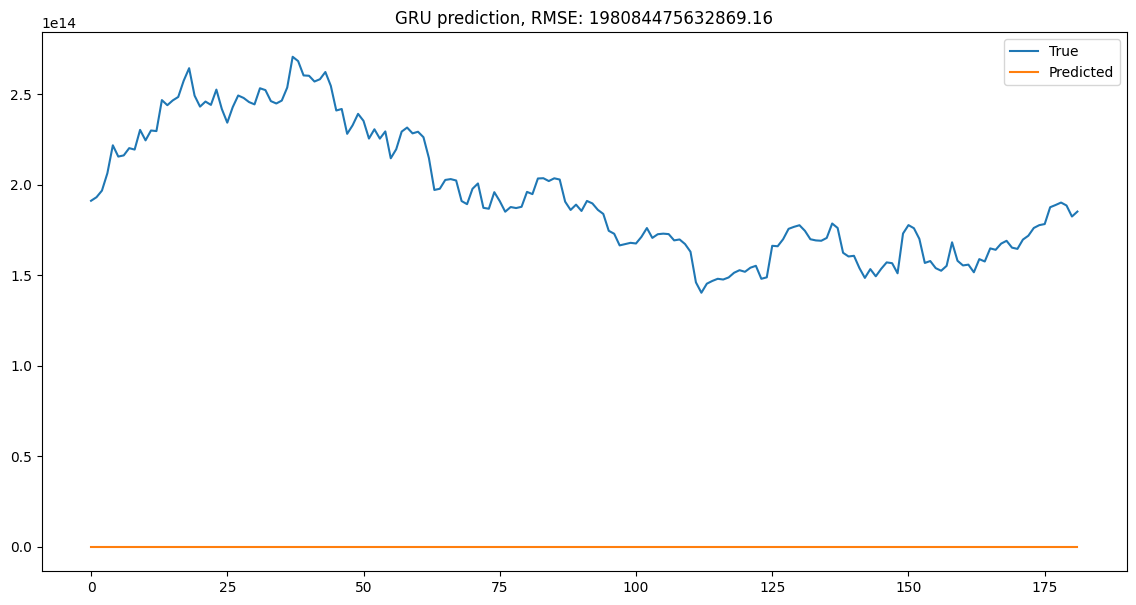

In [ ]:
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

Y_test_p2 = Y_scaler_p2.inverse_transform(Y_test_p2.reshape(-1, 1))
Y_pred = hyper_model.predict(X_test_p2)
Y_pred = Y_scaler_p2.inverse_transform(Y_pred)

rmse = root_mean_squared_error(Y_test_p2, Y_pred)
plt.figure(figsize=(14, 7))
plt.plot(Y_test_p2, label='True')
plt.plot(Y_pred, label='Predicted')
plt.title(f'GRU prediction, RMSE: {rmse}')
plt.legend()
plt.show()